In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np

import ujson
import attr
import random
import torch

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from boltons.iterutils import pairwise, chunked_iter
from collections import Counter

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [3]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [776]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)

In [795]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def tensor(self):
        return torch.stack([s.tensor() for s in self.sentences])

In [796]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [797]:
class Model(nn.Module):
    
    def __init__(self, embed_dim):
        super().__init__()
        self.hidden_out = nn.Linear(2*embed_dim, 1)
        
    def forward(self, x):
        y = F.sigmoid(self.hidden_out(x))
        return y

In [798]:
train = Corpus('../data/train.json/*.json', 1000)

In [695]:
torch.manual_seed(1)

In [606]:
model = Model(300)

In [607]:
criterion = nn.BCELoss()

In [608]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [609]:
def train_pair(model, s1, s2, y):
    
    x = Variable(torch.cat([s1.mean(0), s2.mean(0)]))
    y = Variable(torch.FloatTensor([y]))
        
    model.zero_grad()
    
    y_pred = model(x)

    loss = criterion(y_pred, y)
    loss.backward()

    optimizer.step()
    
    return loss.data[0]

In [610]:
train_loss = []
for epoch in range(50):
    
    epoch_loss = 0
    for ab in train.abstracts():
        for s1, s2 in pairwise(ab.tensor()):
            epoch_loss += train_pair(model, s1, s2, 1)
            epoch_loss += train_pair(model, s2, s1, 0)
    
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch}')
    print(epoch_loss)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 0
6138.540605217218


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1
6077.515937805176


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2
6047.171836435795


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3
6027.26710550487


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4
6012.083196043968


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5
5999.641652002931


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6
5989.0848075300455


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7
5979.9466329813


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8
5971.928203299642


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9
5964.818123802543


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10
5958.45857091248


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11
5952.727909177542


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12
5947.530549839139


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13
5942.790024191141


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14
5938.4443599283695


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15
5934.442765265703


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16
5930.743182972074


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17
5927.3104002177715


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18
5924.114813446999


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19
5921.131107658148


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20
5918.337801769376


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21
5915.716262921691


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22
5913.25027500093


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23
5910.925800636411


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24
5908.73050801456


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25
5906.65347994864


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26
5904.68506796658


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27
5902.816716730595


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28
5901.040785074234


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29
5899.350391447544


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30
5897.739425078034


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31
5896.202272832394


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32
5894.733905136585


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33
5893.3297777324915


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34
5891.985747247934


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35
5890.697965964675


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36
5889.463056385517


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37
5888.27775876224


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38
5887.139207109809


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39
5886.044671326876


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40
5884.991697907448


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41
5883.978033810854


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42
5883.001501560211


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43
5882.060167893767


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44
5881.152209043503


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45
5880.275874853134


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46
5879.429628379643


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47
5878.611920177937


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48
5877.821524821222


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49
5877.05702034384


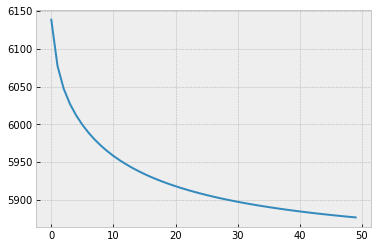

In [611]:
plt.plot(train_loss)

In [612]:
correct = 0
total = 0
for ab in train.abstracts():
    for s1, s2 in pairwise(ab.tensor()):
        
        x = Variable(torch.cat([s1.mean(0), s2.mean(0)]))
        if model(x).round().data[0] == 1:
            correct += 1
        
        x = Variable(torch.cat([s2.mean(0), s1.mean(0)]))
        if model(x).round().data[0] == 0:
            correct += 1

        total += 2

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [613]:
correct / total

0.6018373291507955

In [808]:
ab = list(train.abstracts())[10]

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [809]:
x = Variable(ab.tensor())

In [810]:
x

Variable containing:
( 0 ,.,.) = 
 -0.0168 -0.0669  0.1465  ...   0.0253 -0.0315  0.0806
  0.1992 -0.0806 -0.2119  ...   0.0255 -0.0972  0.1895
 -0.0786 -0.0520  0.0447  ...  -0.3262 -0.0505 -0.3145
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 1 ,.,.) = 
 -0.0275  0.0459  0.3438  ...   0.1177  0.1865  0.0393
  0.0349  0.0850  0.0625  ...  -0.0190 -0.0089  0.0221
  0.1807  0.1235  0.0903  ...   0.1240 -0.0723 -0.0605
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 2 ,.,.) = 
 -0.1729  0.2793  0.1069  ...   0.1230  0.1299 -0.1826
  0.2041  0.1050 -0.0806  ...   0.0527 -0.0952 -0.1484
  0.1416  0.0270 -0.0201  ...   0.0056  0.0967  0.3594
   

In [811]:
rnn = nn.RNN(300, 150, nonlinearity='relu', batch_first=True)
hidden = Variable(torch.zeros(1, 1, 150))
out, hidden = rnn(x, hidden)
hidden

Variable containing:
( 0 ,.,.) = 

Columns 0 to 8 
   0.0356  0.0000  0.0000  0.0194  0.0000  0.0000  0.1011  0.0000  0.0000
  0.0356  0.0000  0.0000  0.0194  0.0000  0.0000  0.1011  0.0000  0.0000
  0.0356  0.0000  0.0000  0.0194  0.0000  0.0000  0.1011  0.0000  0.0000
  0.0356  0.0000  0.0000  0.0194  0.0000  0.0000  0.1011  0.0000  0.0000
  0.0356  0.0000  0.0000  0.0194  0.0000  0.0000  0.1011  0.0000  0.0000
  0.0356  0.0000  0.0000  0.0194  0.0000  0.0000  0.1011  0.0000  0.0000

Columns 9 to 17 
   0.1157  0.0308  0.0566  0.0539  0.0075  0.1113  0.0024  0.1004  0.0656
  0.1157  0.0308  0.0566  0.0539  0.0075  0.1113  0.0024  0.1004  0.0656
  0.1157  0.0308  0.0566  0.0539  0.0075  0.1113  0.0024  0.1004  0.0656
  0.1157  0.0308  0.0566  0.0539  0.0075  0.1113  0.0024  0.1004  0.0656
  0.1157  0.0308  0.0566  0.0539  0.0075  0.1113  0.0024  0.1004  0.0656
  0.1157  0.0308  0.0566  0.0539  0.0075  0.1113  0.0024  0.1004  0.0656

Columns 18 to 26 
   0.0000  0.0000  0.0000  0.0452 

In [803]:
s1 = torch.FloatTensor([[1,2], [3,4], [5,6]])
s2 = torch.FloatTensor([[7,8], [9,10], [11,12]])
s3 = torch.FloatTensor([[13,14], [15,16], [17,18]])
s4 = torch.FloatTensor([[19,20], [21,22], [23,24]])

In [804]:
s1


 1  2
 3  4
 5  6
[torch.FloatTensor of size 3x2]

In [805]:
x = Variable(torch.stack([s1, s2, s3, s4]))

In [806]:
x

Variable containing:
(0 ,.,.) = 
   1   2
   3   4
   5   6

(1 ,.,.) = 
   7   8
   9  10
  11  12

(2 ,.,.) = 
  13  14
  15  16
  17  18

(3 ,.,.) = 
  19  20
  21  22
  23  24
[torch.FloatTensor of size 4x3x2]

In [807]:
rnn = nn.RNN(2, 10, nonlinearity='relu', batch_first=True)
hidden = Variable(torch.zeros(1, 1, 10))
out, hidden = rnn(x, hidden)
hidden

Variable containing:
(0 ,.,.) = 

Columns 0 to 7 
    0.0000   2.6713   3.9650   1.7222   0.7618   0.0000   1.0681   2.7089
   0.0000   5.5870   7.6613   2.9625   1.9638   0.0000   2.2065   6.2723
   0.0000   8.5041  11.3391   4.2342   3.1678   0.0000   3.3529   9.8428
   0.0000  11.4212  15.0168   5.5058   4.3717   0.0000   4.4992  13.4134

Columns 8 to 9 
    0.9803   0.0000
   3.0082   0.0000
   5.0608   0.0000
   7.1135   0.0000
[torch.FloatTensor of size 1x4x10]